In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [8]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [9]:
print(tf.__version__)

2.12.0


In [10]:
tf.random.set_seed(42)
np.random.seed(42)

In [11]:
train_df = pd.read_csv('data/train.csv').drop('Date',axis=1)
val_df = pd.read_csv('data/val.csv').drop('Date',axis=1)
test_df = pd.read_csv('data/test.csv').drop('Date',axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(2242, 15) (641, 15) (294, 15)


In [12]:
train_df

,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_14,EMA_7,EMA_14,RSI,Stoch_RSI,Upper_BB,Lower_BB,MACD
0,0.011040,0.010060,0.011691,0.011455,0.011455,0.000439,0.009202,0.007570,0.008746,0.008162,0.524163,0.991932,0.008637,0.009439,0.362633
1,0.011516,0.009584,0.011555,0.011141,0.011141,0.000261,0.009528,0.007614,0.008987,0.008336,0.514017,0.965996,0.008490,0.009533,0.363263
2,0.011185,0.009412,0.010720,0.010513,0.010513,0.000284,0.009664,0.007644,0.009003,0.008393,0.501092,0.932954,0.008329,0.009612,0.363538
3,0.010580,0.008741,0.010843,0.010575,0.010575,0.000104,0.009838,0.007739,0.009030,0.008452,0.563976,1.000000,0.008214,0.009669,0.363797
4,0.010643,0.009228,0.011034,0.010970,0.010970,0.000074,0.010065,0.007985,0.009155,0.008560,0.744431,1.000000,0.008297,0.009646,0.364169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,0.870440,0.887557,0.890257,0.901869,0.901869,0.439579,0.975791,0.969777,0.955081,0.965048,0.611447,0.195687,0.912614,0.938388,0.605164
2238,0.901622,0.909174,0.924745,0.925526,0.925526,0.419793,0.974289,0.978514,0.960057,0.969711,0.648972,0.306242,0.912705,0.956507,0.597510
2239,0.925196,0.982908,0.957677,1.000000,1.000000,0.643588,0.984129,0.989955,0.983444,0.984510,0.681547,0.402213,0.922338,0.971151,0.617491
2240,1.000000,0.987774,0.965314,0.957690,0.957690,0.669281,0.981755,0.994507,0.989817,0.991224,0.559265,0.041951,0.923794,0.989050,0.614010


## `DataWindow` class 

In [13]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [14]:
def compile_and_fit(model, window, patience=3, max_epochs=1000):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [15]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [16]:
multi_window = DataWindow(input_width=7, label_width=7, shift=7, label_columns=['Adj Close'])

### Repeat last value 

In [17]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 7, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 7, 1])

In [18]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Adj Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 961us/step - loss: 1.1682 - mean_absolute_error: 0.7310


### Repeat last day 

In [19]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [20]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Adj Close'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 894us/step - loss: 1.1829 - mean_absolute_error: 0.7521


## Linear model 

In [21]:
label_index = column_indices['Adj Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 1s 3ms/step - loss: 0.0373 - mean_absolute_error: 0.1377 - val_loss: 0.6057 - val_mean_absolute_error: 0.7162
Epoch 2/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0061 - mean_absolute_error: 0.0642 - val_loss: 0.2106 - val_mean_absolute_error: 0.3935
Epoch 3/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_absolute_error: 0.0427 - val_loss: 0.1028 - val_mean_absolute_error: 0.2526
Epoch 4/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0320 - val_loss: 0.0715 - val_mean_absolute_error: 0.2023
Epoch 5/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0275 - val_loss: 0.0640 - val_mean_absolute_error: 0.1905
Epoch 6/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_absolute_error: 0.0256 - val_loss: 0.0618 - val_mean_absolute_error: 0.1876
Epoch 7/1000
70/

## Dense model 

In [22]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 1s 4ms/step - loss: 0.0242 - mean_absolute_error: 0.0933 - val_loss: 0.0844 - val_mean_absolute_error: 0.2233
Epoch 2/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_absolute_error: 0.0243 - val_loss: 0.0843 - val_mean_absolute_error: 0.2230
Epoch 3/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0228 - val_loss: 0.0683 - val_mean_absolute_error: 0.1976
Epoch 4/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0227 - val_loss: 0.0604 - val_mean_absolute_error: 0.1851
Epoch 5/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0226 - val_loss: 0.0542 - val_mean_absolute_error: 0.1751
Epoch 6/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0221 - val_loss: 0.0885 - val_mean_absolute_error: 0.2344
Epoch 7/1000
70/

## LSTM model 

In [23]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 2s 9ms/step - loss: 0.0320 - mean_absolute_error: 0.1181 - val_loss: 1.5501 - val_mean_absolute_error: 1.1186
Epoch 2/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0051 - mean_absolute_error: 0.0455 - val_loss: 0.8202 - val_mean_absolute_error: 0.7747
Epoch 3/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0329 - val_loss: 0.6278 - val_mean_absolute_error: 0.6631
Epoch 4/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0264 - val_loss: 0.5553 - val_mean_absolute_error: 0.6216
Epoch 5/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0235 - val_loss: 0.5317 - val_mean_absolute_error: 0.6075
Epoch 6/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_absolute_error: 0.0223 - val_loss: 0.5231 - val_mean_absolute_error: 0.6013
Epoch 7/1000
70/

## CNN model 

In [24]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=7, label_columns=['Adj Close'])

In [25]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 1s 4ms/step - loss: 0.0262 - mean_absolute_error: 0.1036 - val_loss: 0.0722 - val_mean_absolute_error: 0.2019
Epoch 2/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0277 - val_loss: 0.0899 - val_mean_absolute_error: 0.2288
Epoch 3/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0019 - mean_absolute_error: 0.0246 - val_loss: 0.0780 - val_mean_absolute_error: 0.2126
Epoch 4/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0761 - mean_absolute_error: 0.2112


## CNN + LSTM model 

In [27]:
cnn_lstm_model = Sequential([
    Conv1D(50, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(50, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 3s 12ms/step - loss: 0.0282 - mean_absolute_error: 0.1013 - val_loss: 1.8639 - val_mean_absolute_error: 1.2345
Epoch 2/1000
70/70 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_absolute_error: 0.0328 - val_loss: 1.6064 - val_mean_absolute_error: 1.1237
Epoch 3/1000
70/70 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0253 - val_loss: 1.4430 - val_mean_absolute_error: 1.0498
Epoch 4/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0238 - val_loss: 1.3739 - val_mean_absolute_error: 1.0236
Epoch 5/1000
70/70 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_absolute_error: 0.0235 - val_loss: 1.3632 - val_mean_absolute_error: 1.0273
Epoch 6/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0234 - val_loss: 1.2649 - val_mean_absolute_error: 0.9768
Epoch 7/1000
70

[1.109283685684204, 0.9275250434875488]

## Autoregressive LSTM 

In [28]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [29]:
AR_LSTM = AutoRegressive(units=32, out_steps=7)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 2s 9ms/step - loss: 0.0245 - mean_absolute_error: 0.0962 - val_loss: 2.0095 - val_mean_absolute_error: 1.2832
Epoch 2/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0026 - mean_absolute_error: 0.0337 - val_loss: 1.6649 - val_mean_absolute_error: 1.1511
Epoch 3/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0284 - val_loss: 1.4987 - val_mean_absolute_error: 1.0862
Epoch 4/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_absolute_error: 0.0255 - val_loss: 1.3622 - val_mean_absolute_error: 1.0261
Epoch 5/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0238 - val_loss: 1.3092 - val_mean_absolute_error: 1.0028
Epoch 6/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0230 - val_loss: 1.2544 - val_mean_absolute_error: 0.9799
Epoch 7/1000
70/

In [30]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 2s 9ms/step - loss: 0.0316 - mean_absolute_error: 0.1153 - val_loss: 2.0307 - val_mean_absolute_error: 1.2968
Epoch 2/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0346 - val_loss: 1.7107 - val_mean_absolute_error: 1.1654
Epoch 3/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0022 - mean_absolute_error: 0.0276 - val_loss: 1.5884 - val_mean_absolute_error: 1.1122
Epoch 4/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0251 - val_loss: 1.4808 - val_mean_absolute_error: 1.0639
Epoch 5/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0242 - val_loss: 1.4528 - val_mean_absolute_error: 1.0586
Epoch 6/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0238 - val_loss: 1.3818 - val_mean_absolute_error: 1.0238
Epoch 7/1000
70/

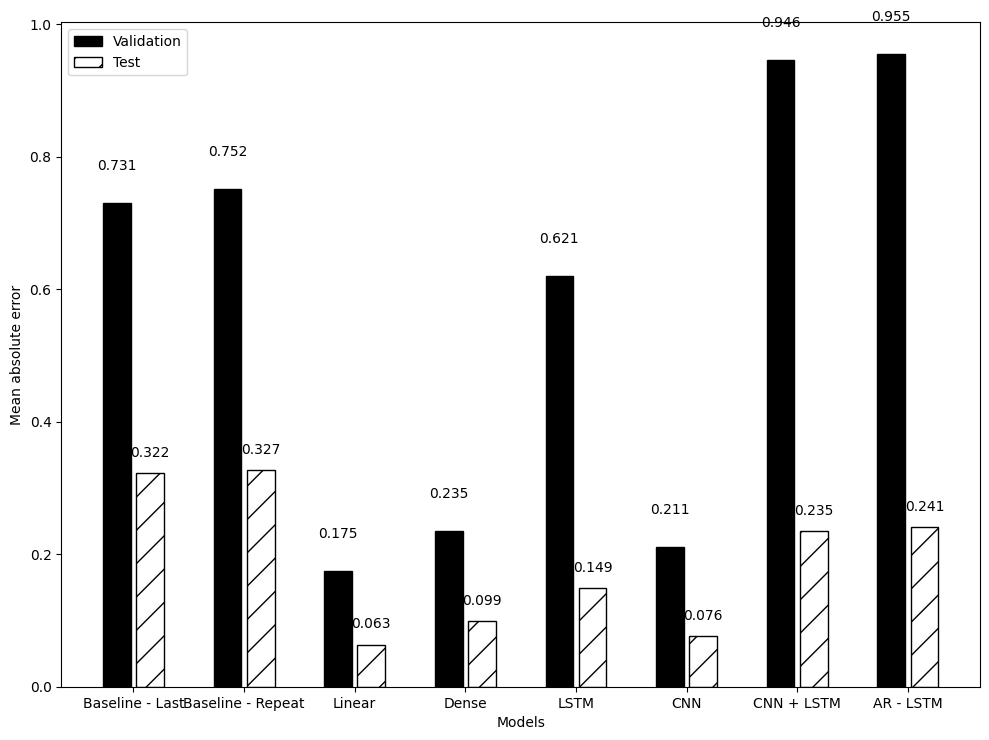

In [31]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.05, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.025, s=str(round(value, 3)), ha='center')

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)